# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import json
import yaml
# import pydot
import operator
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from csv import reader
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from random import seed, randrange
from collections import defaultdict
import matplotlib.patches as mpatches


# Imports for DF and MLIB
from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions
import pyspark.sql.functions as func
from pyspark.sql.functions import col, countDistinct, approxCountDistinct, count, when, desc
from pyspark.ml.feature import QuantileDiscretizer, Bucketizer
from pyspark.sql import DataFrameStatFunctions as statFunc

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation


### Background 

The following analysis is based on a Kaggle dataset from Criteo, an internet advertising company focused on retargeting. Criteo's goal is to increase online clickthrough rates among consumers who have previously visited an advertiser's website. This information will be used by Criteo to more efficiently provide the right ads to the right people. Optimizing the retargeting process not only helps advertisers become more efficient in terms of how they spend their dollars, but also it reduces clutter for consumers who do not want to be "followed" by ads for irrelevant products (or ones they may have already purchased!). **Our goal is to create a model that will most accurately predict clickthroughs (label = 1); Due to binary categorical nature of the output label (0,1), we are exploring classification models for analysis.** 

Features given in the data set most likely represent characterstics about consumer behavior (history of clickthroughs, site visitiation, etc.), the ads themselves (product, creative approach, placement, etc.) and general metrics such as the date the ad was published.  However **since there is no visibility into what each feature represents, our challenge is to make our predictions based on the data alone. With over 6 million records to train each day (~45 million per week), this will require a scalable approach**.


### Dataset Introduction 

The training dataset consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo and the first column indicates whether this ad has been clicked or not. The positive (clicked) and negatives (non-clicked) examples have both been subsampled (but at different rates 75% - 0 Class, 25% - Class) in order to reduce the dataset size.

**There are 13 numerical features (mostly count features) and 26 categorical features in this dataset. The values of the categorical features have been hashed onto 32 bits for anonymization purposes. The semantic of these features is undisclosed**. Some features may have missing values. All the rows are chronologically ordered. The test set is computed in the same way as the training set but it corresponds to events on the day following the training period and does not have the label column. Since, there is no time data available, we are not considering this dataset to be a time series model.


### Key Questions: Features and Model

#### 1. Which features are most important in predicting clickthroughs?

Having this information can help Criteo focus on the metrics that are most critical to their product. With 39 features, there is a high risk of overfitting. We should identify a model that provides an optimal tradeoff between bias and variance. **Since we didnt get any metadata about the features, we are relying on EDA and regularization techniques to help us determine the important features and reduce dimensionality of the feature space**.


#### 2. Which machine learning approach not only provides the highest accuracy in predicting clickthroughs, but is also scalable enough to be useful in a production environment?

As internet patterns and product choices change rapidly, the ideal model should be trained daily to update the following day's retargeting model. Scaling would help us achieve shorter training times than processing records sequentially. **Any ML algorithm which can be trained using associative and commutative properties (ex. simple addition, with no state dependencies) such as Batch Logisitc Regression or Graph (Anusha Check 1: Is it graph or tree?) Algorithms based can be used for scaling the training approach.**

## 2. EDA & Discussion of Challenges

### Goals for this section:

#### PART A: Loading and Creating files with pre-processing 

1. Create RDDs for full train and test files. 
2. Sample full train RDD to create trainRDD for training, heldOutRDD for testing and a random sample of 1000 rows as toy dataset for demonstration purpose ('toy1000.txt').
3. Take another random sample of 300 rows from the train file ('toy_test300.txt') which will be used to validate ML models in later sections. 

#### PART B: EDA with Toy Dataset and RDDs/Pandas

Perform EDA on toy dataset using pandas/RDDs including visualizations that help inform our data transformation decisions.  

#### PART C:  EDA on Full Dataset with Dataframes 

Perform EDA on full train dataset using Dataframes.

#### PART D: Data Transformation on Toy Dataset
Data transformations using Spark RDDs on toy dataset.  

**NOTE: In section 4, we perform the same data transformations on the entire dataset using Spark Dataframes for Spark ML models.**

### PART A: LOADING AND CREATING FILES WITH PRE-PROCESSING

### Files and Columns Details:

1. **Full Train File 'train.txt'**:  Number of rows: 45840617 (~ 45 million; ~ 10 GB) 40 columns
2. **Full Test File 'test.txt'**: Number of rows: 6042135 (~ 6 million; 1.4 GB) 39 columns (all columns except label column)
3. **Toy Train File 'toy100.txt'**: A random sample of 1000 rows as toy dataset for demonstration purpose with the same number of columns as the train file. 
4. **Toy Test File 'toy_test300.txt'**: A random sample of 300 rows as toy test dataset with the same of columns as the train file and validation of ML models in later section. 
4. **Columns**: 40
    -  13 Numerical Features I1-I13
    -  26 Categorical Features C1-C26
    -  1 Label Column - 0 or 1   

### 2.1 Data Loading

In [4]:
# take a look at the full train file data top row 
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# load the full train and test files
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

# Get categorical and numeric field names separately
NUM_FIELDS = FIELDS[0:13]
CAT_FIELDS = list(set(FIELDS)-set(NUM_FIELDS))

In [7]:
# number of rows in full train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


### 2.2 Creating Train and Test Split

In [27]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


### 2.3 Creating a toy RDD

#### 2.3.1 Toy Train Set 

A train toy data set was created by randomly sampling 1000 records from the dataset: 

`!gshuf -n 1000 data/train.txt >> data/toy1000.txt`

In [6]:
toyRDD = sc.textFile('data/toy1000.txt')
print(f"Number of records in toy data: {toyRDD.count()} ...")

Number of records in toy data: 1000 ...


In [7]:
print(toyRDD.take(1))

['1\t0\t478\t13\t\t3396\t194\t11\t13\t312\t0\t7\t\t\t05db9164\t207b2d81\t1757640a\t06148e59\t25c83c98\tfbad5c96\tf36791d8\t0b153874\ta73ee510\tc7009b63\t2714650d\t1a69f1c0\t9a88e2e2\t07d13a8f\t0c67c4ca\t8075af0c\te5ba7672\t395856b0\t21ddcdc9\tb1252a9d\t8e4884c0\t\t423fab69\tb936bfbe\t001f3601\tf2fc1d6e']


#### 2.3.1 Toy Test Set 

We will randomly sample a toy held-out dataset frim the `train.txt` file.

`!gshuf -n 300 data/train.txt >> data/toy_test300.txt`

In [8]:
toy_testRDD = sc.textFile('data/toy_test300.txt')

### 2.4 Pre-Processing

In [9]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append('null')
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [28]:
# Parsing, making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()
toyRDDCached = toyRDD.map(parse).map(edit_data_types).cache()

In [29]:
print(trainRDDCached.take(1))

[([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, 'null', 2.0, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', 'null', '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], 0)]


In [11]:
print(toyRDDCached.take(1))

[([0.0, 478.0, 13.0, 'null', 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 'null', 'null', '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.4.1 Some extra pre-processing for a pandas DataFrame for EDA use

In [12]:
# helper function 'null' to np.nan for pandas df 
def null_to_nan(line):
    """
    converts "null" to np.nan in RDD
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == 'null':
            formated_features.append(np.nan)
        else:
            formated_features.append(value)
    return (formated_features, label)

# put the toy RDD into a pandas dataframe for EDA charting
toyRDDtoPandas = toyRDDCached.map(null_to_nan) \
                                .map(lambda x: np.append(x[0], [x[1]])) \
                                .collect()

toy_df = pd.DataFrame(toyRDDtoPandas, columns=FIELDS)

In [13]:
toy_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.0,478.0,13.0,nan,3396.0,194.0,11.0,13.0,312.0,0.0,...,395856b0,21ddcdc9,b1252a9d,8e4884c0,nan,423fab69,b936bfbe,001f3601,f2fc1d6e,1
1,2.0,0.0,nan,nan,1209.0,0.0,2.0,1.0,0.0,1.0,...,526e8765,nan,nan,8b7fb864,nan,32c7478e,45b2acf4,nan,nan,0
2,nan,1.0,1.0,8.0,489.0,66.0,0.0,11.0,8.0,nan,...,8f9b4e88,nan,nan,050a23dc,nan,32c7478e,8a3cfad4,nan,nan,0
3,0.0,179.0,7.0,8.0,996.0,67.0,6.0,44.0,344.0,0.0,...,2804effd,nan,nan,723b4dfd,nan,32c7478e,b34f3128,nan,nan,0
4,2.0,2.0,10.0,27.0,1101.0,29.0,11.0,42.0,241.0,1.0,...,e88ffc9d,21ddcdc9,b1252a9d,dca9a28d,ad3062eb,bcdee96c,3fdb382b,cb079c2d,1c2df582,1


### PART B: EDA WITH TOY DATASET USING RDDs/PANDAS

### 2.5 Labels

First we take a look at the percentage of records that belong to each label for our classification problem in order to determine whether our classes are balanced. 

In [14]:
# TOY DATA
# counting records for each class 
count_label_0 = toyRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = toyRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

72.3 % of the records have label=0 and 27.7 % have label=1...


In [13]:
# FULL DATA  ( Don't re-run this!!! )
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


The result above show that the **labels are imbalanced**, with 75% of records having label=0 (i.e. unclicked ads). However, we will not attempt to balance the labels at this stage. **Being aware of this imbalance, we will carefully examine the prediction results to detect any model bias (i.e. predicting always label=0)**

### 2.6 Counting nulls in each column

Then, we take a look at the percentage of null values for all columns in our dataset. 

In [15]:
def get_pct_nulls_in_column(dataRDD, var_position):
    """
    Counts the % nulls in a column 
    """

    null_count = dataRDD.map(lambda x: x[0][var_position]) \
                             .filter(lambda x: x == 'null').count()
    total_count = dataRDD.map(lambda x: x[0][var_position]).count()

    return null_count/total_count*100

In [16]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position < 39:
        null_pct = get_pct_nulls_in_column(toyRDDCached, var_position)
        print("FEATURE {}: {}% is null".format(var, np.round(null_pct,2)))

FEATURE I1: 43.2% is null
FEATURE I2: 0.0% is null
FEATURE I3: 21.3% is null
FEATURE I4: 22.1% is null
FEATURE I5: 2.4% is null
FEATURE I6: 23.0% is null
FEATURE I7: 3.7% is null
FEATURE I8: 0.0% is null
FEATURE I9: 3.7% is null
FEATURE I10: 43.2% is null
FEATURE I11: 3.7% is null
FEATURE I12: 77.4% is null
FEATURE I13: 22.1% is null
FEATURE C1: 0.0% is null
FEATURE C2: 0.0% is null
FEATURE C3: 3.4% is null
FEATURE C4: 3.4% is null
FEATURE C5: 0.0% is null
FEATURE C6: 13.4% is null
FEATURE C7: 0.0% is null
FEATURE C8: 0.0% is null
FEATURE C9: 0.0% is null
FEATURE C10: 0.0% is null
FEATURE C11: 0.0% is null
FEATURE C12: 3.4% is null
FEATURE C13: 0.0% is null
FEATURE C14: 0.0% is null
FEATURE C15: 0.0% is null
FEATURE C16: 3.4% is null
FEATURE C17: 0.0% is null
FEATURE C18: 0.0% is null
FEATURE C19: 42.2% is null
FEATURE C20: 42.2% is null
FEATURE C21: 3.4% is null
FEATURE C22: 74.5% is null
FEATURE C23: 0.0% is null
FEATURE C24: 3.4% is null
FEATURE C25: 42.2% is null
FEATURE C26: 42.2%

We notice that some columns have a high % of null values. **We could exclude columns that have more than 50% nulls when calculated on full train dataset because those columns will likely not contribute a lot to the prediction results. However, since those variables with more than 50% missing values are categorical variables, the one-hot encoding approach that we will take later on will take care of this issue**.

### 2.7 Numeric Features

#### 2.7.1 Get Summary Statistics and Distributions

Next, we take a look at the summary statistics for our numerical features in order to determine their distributions and detect outliers. 

In [17]:
# RDD version 
def get_stats(dataRDD, var_position):
    """
    Get statistics for numeric variables 
    stats: mean, median, variance, min, max 
    """

    mean = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').mean() 
    variance = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').variance() 
    minimum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').min() 
    maximum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').max() 

    return mean, variance, minimum, maximum

In [18]:
# save the means in a dictionary
mean_dict_toy = {}
st_dev_dict_toy = {}

# get summary stats with RDDs
for var_position, var in enumerate(FIELDS):
    if var_position < 13:
        mean, variance, minimum, maximum = get_stats(toyRDDCached, var_position)
        print("FEATURE {}: \t mean={}, \t variance={}, \t min={}, \t max={}".format(var, np.round(mean, 2), np.round(variance, 2), minimum, maximum))
        mean_dict_toy[var_position] = mean
        st_dev_dict_toy[var_position] = np.sqrt(variance)

FEATURE I1: 	 mean=3.17, 	 variance=33.98, 	 min=0.0, 	 max=55.0
FEATURE I2: 	 mean=114.72, 	 variance=179230.84, 	 min=-2.0, 	 max=5123.0
FEATURE I3: 	 mean=18.78, 	 variance=2026.69, 	 min=0.0, 	 max=648.0
FEATURE I4: 	 mean=7.43, 	 variance=86.02, 	 min=0.0, 	 max=77.0
FEATURE I5: 	 mean=18392.77, 	 variance=4908735552.87, 	 min=0.0, 	 max=1002457.0
FEATURE I6: 	 mean=95.23, 	 variance=65007.31, 	 min=0.0, 	 max=4304.0
FEATURE I7: 	 mean=17.94, 	 variance=8794.35, 	 min=0.0, 	 max=2614.0
FEATURE I8: 	 mean=12.96, 	 variance=183.6, 	 min=0.0, 	 max=49.0
FEATURE I9: 	 mean=102.42, 	 variance=38152.34, 	 min=0.0, 	 max=2711.0
FEATURE I10: 	 mean=0.64, 	 variance=0.5, 	 min=0.0, 	 max=4.0
FEATURE I11: 	 mean=2.78, 	 variance=23.83, 	 min=0.0, 	 max=60.0
FEATURE I12: 	 mean=1.19, 	 variance=40.19, 	 min=0.0, 	 max=84.0
FEATURE I13: 	 mean=7.99, 	 variance=116.35, 	 min=0.0, 	 max=97.0


In [19]:
# Pandas version 
num_columns = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13']
toy_df_num = toy_df[num_columns].astype(np.float)
toy_df_num.describe()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,568.000000,1000.000000,787.000000,779.000000,9.760000e+02,770.000000,963.000000,1000.000000,963.000000,568.000000,963.000000,226.000000,779.000000
mean,3.167254,114.719000,18.780178,7.427471,1.839277e+04,95.231169,17.942887,12.961000,102.419522,0.642606,2.778816,1.194690,7.993582
std,5.834144,423.568469,45.047402,9.280591,7.009829e+04,255.131025,93.826907,13.556669,195.427732,0.705795,4.884305,6.353803,10.793634
min,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2.000000,3.032500e+02,6.000000,1.000000,2.000000,10.500000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,2.000000,6.000000,4.000000,2.696000e+03,28.000000,3.000000,8.000000,39.000000,1.000000,1.000000,0.000000,4.000000
75%,4.000000,32.000000,18.000000,10.000000,9.703500e+03,92.750000,12.000000,20.000000,101.000000,1.000000,3.000000,0.000000,10.000000
max,55.000000,5123.000000,648.000000,77.000000,1.002457e+06,4304.000000,2614.000000,49.000000,2711.000000,4.000000,60.000000,84.000000,97.000000


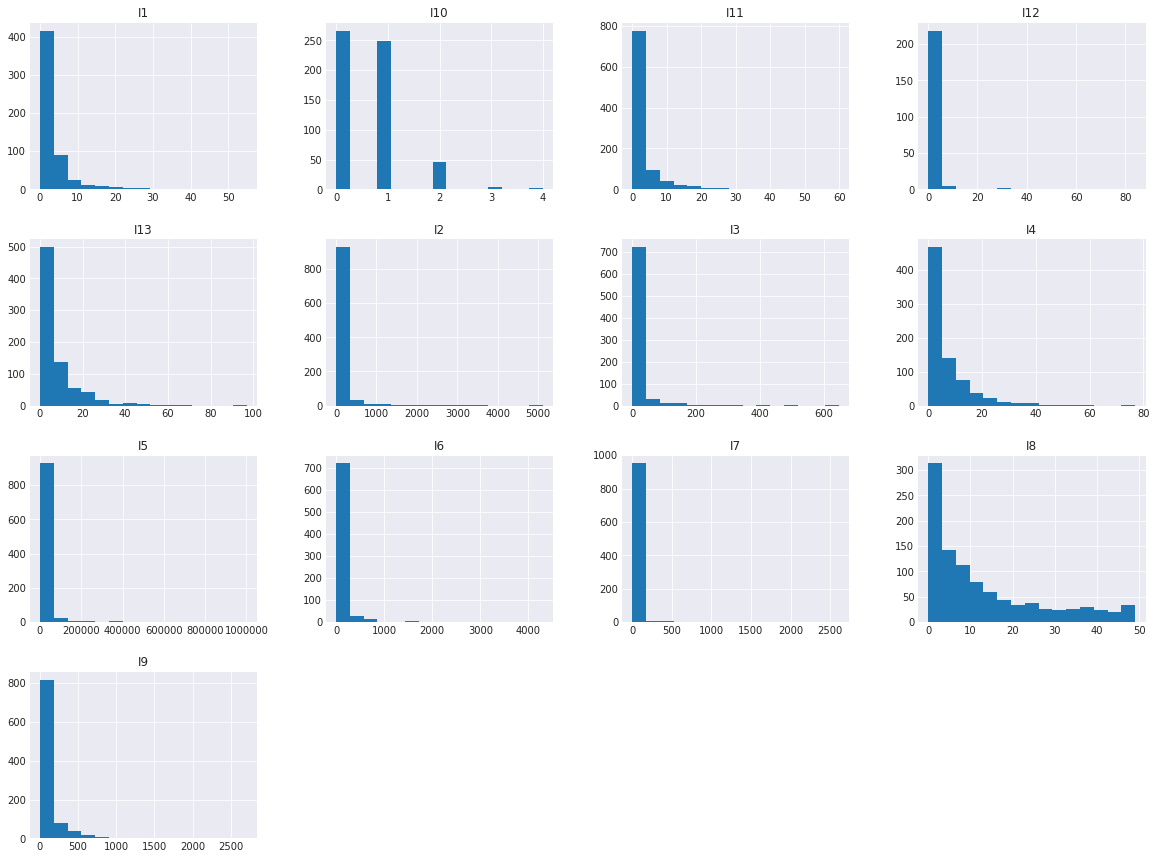

In [20]:
# Take a look at histograms for each numeric feature 
toy_df_num.hist(figsize=(20,15), bins=15)
plt.show()

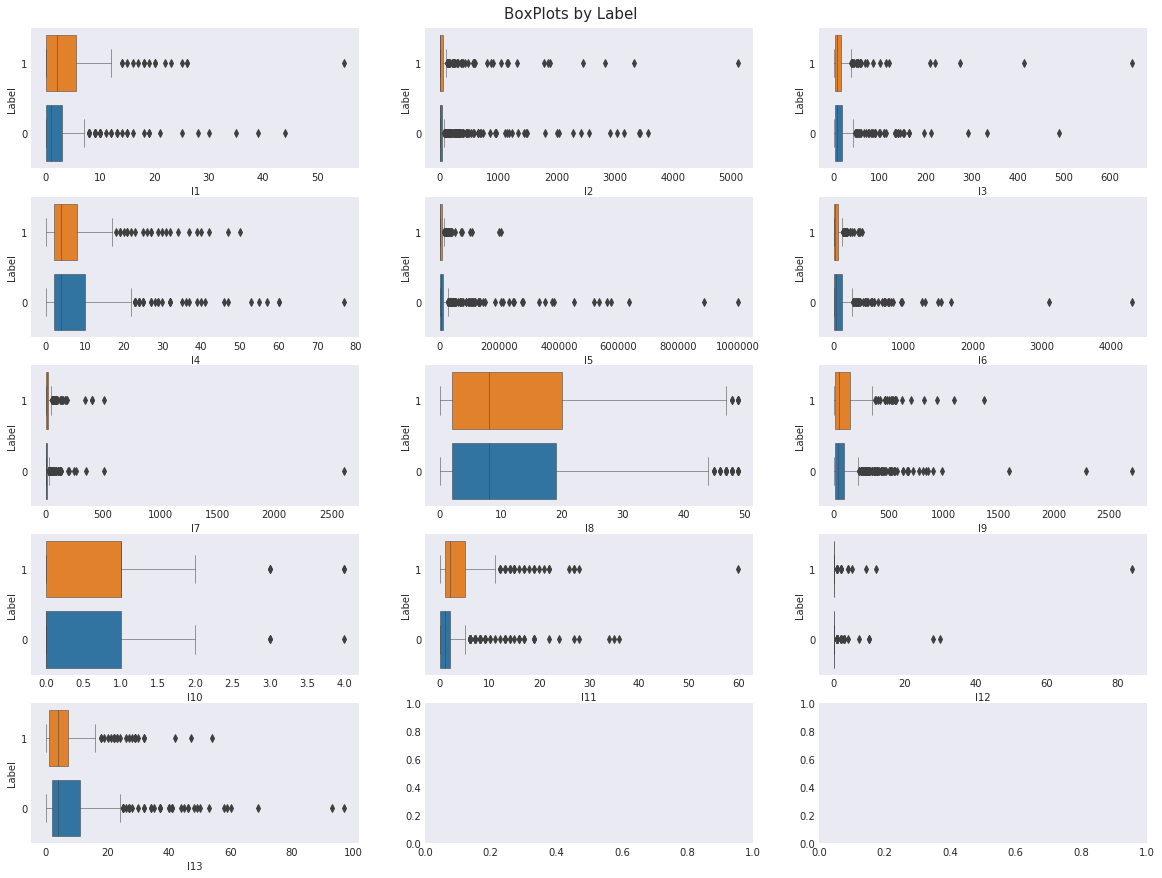

In [21]:
# plot boxplots of each feature vs. the outcome
fig, ax_grid = plt.subplots(5, 3, figsize=(20,15))
y = toy_df['Label']
for idx, feature in enumerate(num_columns):
    x = toy_df_num[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

**The above results show that most of the numeric features are heavily skewed with several outliers on the right end. Hence, we decided to impute the missing values in the numeric features with median value for each corresponding column than mean as mean will be skewed due to the large number of outliers.** 

#### 2.7.2 Correlations

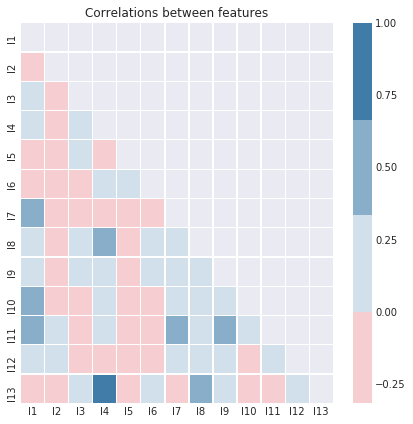

In [22]:
# Correlation between numerical features
corr = toy_df_num.corr()
fig, ax = plt.subplots(figsize=(7, 7))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=False)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.2)
plt.title("Correlations between features")
plt.show()

**We observe that some of the numerical variables are highly correlated with each other. In the context of Logistic Regression we would want to eliminate features that are highly correlated with each other. A regularization  technique like Lasso or Ridge could take care of this. However, since Logistic regression is just our baseline model and we are focusing on tree-based algorithms, we do not need to worry about this. Tree-based models know how to assign variable importance and do not require any significant feature engineering.** 

### 2.8 Categorical Features

In this section, we will perform data processing on the 26 categorical features of the dataset. We will start by performing some EDA to compute the **number of unique categories** within each categorical feature and the total counts for each category. 

In [23]:
def count_categories(dataRDD, var, var_position, top):
    """
    input: RDD, name and position of a categorical variable 
    
    output: 
    * number of unique categories in the variable
    * counts of each category occurance by label
    """
    
    # counting category occurance within each categorical feature 
    count_per_category = dataRDD.map(lambda x: ( x[0][var_position], 1)) \
                                           .reduceByKey(lambda x,y: x+y) \
                                           .sortBy(lambda x: -x[1])

    # counting number of unique values within the categorical variable
    num_unique_values = count_per_category.map(lambda x: x[0]).distinct().count()

    print('Unique values within the category:', num_unique_values)
    print(' ')
    top_x = count_per_category.take(top)
    print('Top {} categories by count:'.format(top))
    for i in top_x: 
        print('Category: {}; Count: {}'.format(i[0],i[1]))
    print(' ')

In [25]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position > 12 and var_position < 39:
        print(" ")
        print("VARIABLE {}".format(var))
        print(" ")
        count_categories(toyRDDCached, var, var_position=var_position, top=10)

 
VARIABLE C1
 
Unique values within the category: 57
 
Top 10 categories by count:
Category: 05db9164; Count: 485
Category: 68fd1e64; Count: 146
Category: 5a9ed9b0; Count: 103
Category: 8cf07265; Count: 51
Category: be589b51; Count: 41
Category: 5bfa8ab5; Count: 27
Category: f473b8dc; Count: 20
Category: 87552397; Count: 15
Category: 39af2607; Count: 13
Category: 9a89b36c; Count: 9
 
 
VARIABLE C2
 
Unique values within the category: 193
 
Top 10 categories by count:
Category: 38a947a1; Count: 114
Category: 1cfdf714; Count: 50
Category: 287130e0; Count: 46
Category: 38d50e09; Count: 46
Category: 207b2d81; Count: 37
Category: 09e68b86; Count: 33
Category: 421b43cd; Count: 33
Category: 4f25e98b; Count: 29
Category: 89ddfee8; Count: 27
Category: 58e67aaf; Count: 27
 
 
VARIABLE C3
 
Unique values within the category: 771
 
Top 10 categories by count:
Category: null; Count: 34
Category: d032c263; Count: 15
Category: 02cf9876; Count: 13
Category: b00d1501; Count: 12
Category: 77f2f2e5; Cou

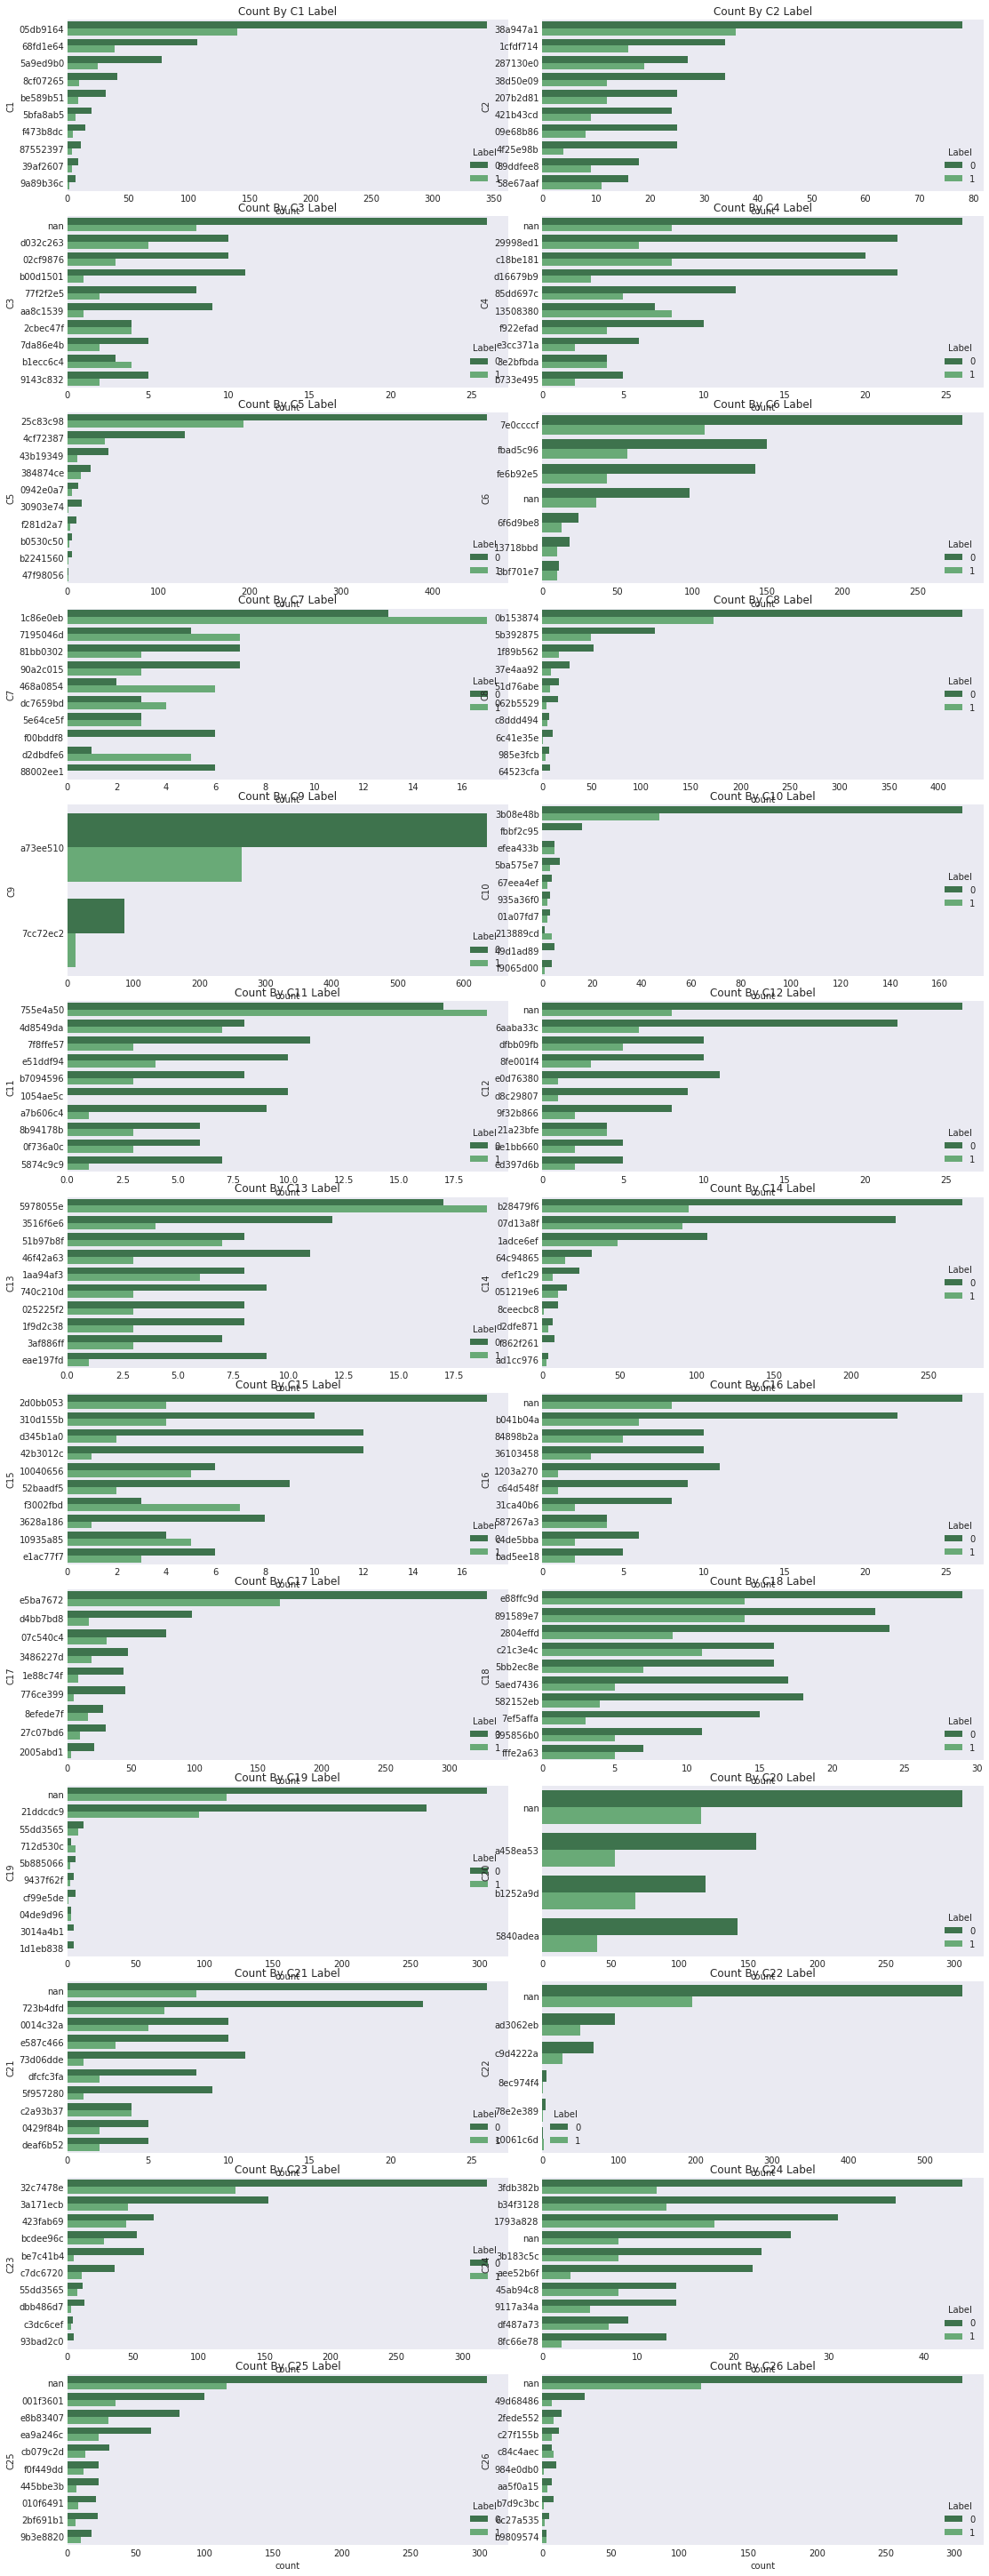

In [26]:
# Bar graphs of category counts within each categorical variable by label
fig, ax = plt.subplots(13, 2,figsize=(15,40))
plt.tight_layout()
fno = 0
# axes are in a two-dimensional array, indexed by [row, col]
for i in range(13):
    for j in range(2):
        fno += 1
        col = "C" + str(fno)
        sns.countplot(y=col, hue="Label", data=toy_df, palette="Greens_d",
                  order=toy_df[col].value_counts().iloc[:10].index,ax=ax[i,j]).set_title('Count By C'+str(fno)+' Label')

**The above analysis shows that some categorical variables have a high number of unique categories. Aditionally, the distribution of counts for most of the categorical variables is very skewed (i.e. some categories appear much more often than others). Considering this information, we decided to bucket the categorical features into 'High', 'Medium', 'Rare' and 'Missing' buckets for each column which will be explained later in the data transformation section.** 

### PART C:  EDA ON FULL DATASET USING DATAFRAMES

### 2.9 Creating a dataframe for TrainRDD (from above)

In [ ]:
sampleDF = trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).map(lambda x: x.tolist()).toDF(FIELDS).cache()
                                                                   
# Converting Columns to Numeric Type
for col_name in NUM_FIELDS:
    sampleDF = sampleDF.withColumn(col_name, col(col_name).cast('float'))
sampleDF = sampleDF.withColumn("Label", col("Label").cast('int')).cache()

# Show col types and top row
print(sampleDF.dtypes)
sampleDF.head(1)

### 2.10 Categorical Features: 

Get missing fields, distinct features count and high/medium frequency features.

* **High Frequency Features:** are those which which occur at least 10% of the time. Ex: if n = 45 million; 10% of n = 4.5million. ie. give me a list of categorical features (categories) in a column that occur at least 10% of the time. 

* **Medium Frequency Features:** Categories that occur 2%-10% of the time in a column

* **Rare and Missing**: After getting the 'High' and 'Medium' frequency features from a column, remaining features would all be clubbed under the 'Rare' category which occur less than 2% of the time or are nulls bucketed as 'Missing'. 

In [ ]:
high_features = dict()
medium_features =  dict()

for field in CAT_FIELDS:
    print("\nFOR COLUMN "+field+":")
    
    columnDF = sampleDF[[field]].cache()
    
    #Count of missing 
    missing_count = columnDF.select(count(when(col(field) == "nan", 1))).head()[0]
    print("No. of Missing Values:", missing_count)
    
    # Distinct
    distinct = columnDF.agg(approxCountDistinct(col(field)).alias(field)).head()[0]
    if missing_count != 0:
        distinct = distinct -1
    print("No. of Distinct Features (without nan):", distinct)
    
    # Frequent Items 
    freq10 = columnDF.stat.freqItems([field], 0.1).head()[0]
    freq5 = columnDF.stat.freqItems([field], 0.02).head()[0]
    freq5 = list(set(freq5) - set(freq10))
    print("10% Occuring Features:", freq10)
    print("2% Occuring Features:", freq5)
    
    high_features[field] = freq10
    medium_features[field] =  freq5

### 2.11 Numerical Features

#### 2.11.1 Summary Stats

In [ ]:
# Get numeric features summary stats
numeric_DF = sampleDF[[NUM_FIELDS]].cache()
numeric_summaryDF= numeric_DF.describe()

# Round numeric summary stats
for field in NUM_FIELDS:
    numeric_summaryDF = numeric_summaryDF.withColumn(field, func.round(numeric_summaryDF[field], 2))

# Display numeric summary stats
numeric_summaryDF[['summary']+NUM_FIELDS[0:7]].show()
numeric_summaryDF[[NUM_FIELDS[7:]]].show()

#### 2.11.2 Column Quantiles to bucket numeric features

Note: values are [min, 25%, median, 75%, max]

In [ ]:
splits = []

# Round numeric summary stats
for field in NUM_FIELDS:
    split = set(statFunc(sampleDF).approxQuantile(field, probabilities = [0.0,0.25,0.50,0.75,1.0], relativeError=0.2))
    splits.append(sorted(list(split)))

print("Column Quantiles:\n")
print(splits)

#### 2.11.3 Bucket each numerical column based on quantiles

In [ ]:
count_buckets = []
buckets = []

for i,field in enumerate(NUM_FIELDS):
    if len(splits[i])==2:
        splits[i] = [-float("inf")] + splits[i] + [float("inf")]
        
    # Bucketize the values
    bucketizer = Bucketizer(handleInvalid = 'skip', splits = splits[i], inputCol=field, outputCol="bucket")
    result = bucketizer.transform(sampleDF[[field]]).cache()
    print("\nFOR COLUMN "+field+":", "splits are:", splits[i])
    
    # Get ccount of each bucket in a column
    bucket = result.groupBy(["bucket"]).agg(count("bucket").alias("count")).orderBy("bucket")
    count_buckets.append([value[1] for value in bucket.collect()])
    buckets.append([value[0] for value in bucket.collect()])
    print(bucket.show())
    
print("Buckets:", buckets)
print("Bucket Counts:", count_buckets)

#### 2.11.4 Visualize each of the bucketed numerical column 

Note: if values are too low, they are not shown in the plot. Look at count values in title to determine which buckets are a minority/outliers.

In [ ]:
for j, field in enumerate(NUM_FIELDS):
    N = len(buckets[j])
    index = np.arange(N)
    bar_width = 0.95
    labels = []

    for i in range(N):
        labels.append(str(splits[j][i]) + "-" + str(splits[j][i+1]))

    plt.bar(buckets[j], count_buckets[j], align='center', alpha=0.5)
    plt.ylabel('Count')
    plt.xticks(index, labels)   
    plt.title('Bar Plot Column: ' + field + '\n'+str(count_buckets[j]))
plt.show()

* **Above plots show that most of the numeric features have outliers beyond the 75% percentile value on the right end but their count is much smaller compared to the other buckets.** Hence, we decided not to do any processing such as removing these outliers and retained them as is. 


* **They are not too many of outliers for the Logistic Regression model estimates to be too skewed by these values (relying on large sample asymptotics and Central Limit Theorem!) while Decision Trees can handle features with outliers.** However, to be on the safe side we decided to use median for imputing the values and standardize the features by computing mean post imputation.

### 2.12 Data Transformation Steps based on EDA  

Based on our EDA on full train dataset, we decided to do the following transformations on columns:

#### A. Numerical Columns:

 **1. Imputing with medians**: 
    
 We decided to impute the missing values in the numeric features with the median value for each corresponding column. **The choice of median instead of mean is made due to the multiple large outliers on the high end that would have caused our mean values to be larger (skewed).** Note, that there is no need to impute the null values for the categorical features since one hot encoding will take care of the nulls later on. 
    
**2. Standardizing**: 
    
In the summary statistics, **we noticed that the numerical features have different ranges for each column, and thus we decided to standardize our data** (i.e. subtracting by mean and dividing by standard deviation of each column), in order to scale them. **Standardization would also help with our Logistic Regression algorithm to coverge faster and use regularization to determine importance of coefficients**.

#### B. Categorical Columns:

**1. Bucketing as 'High', 'Medium', 'Rare', 'Missing':**

**2. One Hot Encoding:**


### PART D: DATA TRANSFORMATION ON TOY DATASET

#### 2.13.1 Impute nulls with medians

In [30]:
def impute_nulls(line, mean_or_median_dict):
    """
    Impute the null values of the numerical columns with the mean value of the column
    """
    features, label = line[0], line[1]
    imputed_features = []
    for i, value in enumerate(features):
        if i < 13: 
            if value == 'null':
                imputed_features.append(mean_or_median_dict[i])
            else:
                imputed_features.append(value)
        else: 
            imputed_features.append(value)
    return (imputed_features, int(label))

In [31]:
# getting the median with pandas because RDDs don't have a built-in function 
medians = toy_df_num.median().tolist()
median_dict_toy = dict(zip(mean_dict_toy.keys(), medians))

In [32]:
# imputing nulls with median 
imputedToyRDDCached = toyRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()

In [33]:
print(imputedToyRDDCached.take(1))

[([0.0, 478.0, 13.0, 4.0, 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 0.0, 4.0, '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### 2.13.2 Standardize features 

In [34]:
def standardize(line, mean_dict, st_dev_dict):
    """
    Scale and center data round mean of each feature (mean=0, sd=1)
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if i < 13: 
            formated_features.append((value-mean_dict[i])/st_dev_dict[i])
        else: 
            formated_features.append(value)

    return (formated_features, label)

In [35]:
# TOY DATA 
normedToyRDDCached = imputedToyRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

#### 2.13.3 Bucketing Categorical features 

The above analysis shows that some categorical variables have a high number of unique categories. Aditionally, the distribution of counts for most of the categorical variables is very skewed (i.e. some categories appear much more often than others). Considering this information, we decided to take the following approach to deal with categorical variables: 

* Bucket the categories within each categorical feature in 4 groups based on their occurence counts
    * **High frequency**: categories that occur more times than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *more than 100 times*)
    * **Medium frequency**: categories that occur more times than 2% and less than 10% of the total row count (Example: if the total row count is 1000 -> categories that occur *50-100 times*)
    * **Low frequency**: categories that occur less times than 2% of the total row count (Example: if the total row count is 1000 -> categories that occur *less than 50 times*)
    * **Missing**: null occurencies (note: since there are a couple of categorical variables with significant percentages of null occurencies, we wanted to retain this information to see if it potentially creates some signal for our models)

* Convert the categorical features to numerical using *One-hot Encoding* and the buckets obtained above. Specifically, each categorical feature will be converted into 4 columns (`high`, `medium`, `low` and `missing`) that will have values of `1`'s and `0`'s denoting whether that record has a value for that categorical variable that belongs in one of the 4 buckets. This is an alternative data transformation method of categorical variables to numerical, instead of the traditional one-hot enconding. The choice for this method is based on the effort to retain all the information/signals from the categorical variables and at the same time reduce the dimensionality of the dataset compared to a traditional one-hot enconding transformation.

Below, we will demonstrate how the bucketing/one-hot encoding that was applied in a scalable manner to our Criteo dataset, using our toy dataset with 1000 rows.

We will use variable `C1` as an example to demonstrate the implementation. The analysis above showed that variable `C1` has 57 uniques categories, hence we will obtain the occurence counts for each of the 57 categories in `C1`. Each of these categories will then be placed in one of the 4 buckets mentioned above based on its occurence counts.

**Step 1**. Obtain the occurence counts for each category.

In [59]:
# C1 has var_position = 13
category_counts_C1 = normedToyRDDCached.map(lambda x: ( x[0][13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])

category_counts_C1.take(10)

[('05db9164', 485),
 ('68fd1e64', 146),
 ('5a9ed9b0', 103),
 ('8cf07265', 51),
 ('be589b51', 41),
 ('5bfa8ab5', 27),
 ('f473b8dc', 20),
 ('87552397', 15),
 ('39af2607', 13),
 ('9a89b36c', 9)]

**Step 2**. Classify each category into one of the 4 buckets mentioned above based on its occurence counts and broadcast this information. As we learned throughout the semester, broadcasted variables are very useful in cases where the programmer wants to pass a copy of some useful information to every node in an efficient manner. 

* `>=` 100 times (i.e. 10% of 1000 rows) -> *High frequency* 
* 20-100 times (i.e. 2-10% of 1000 rows) -> *Medium frequency* 
* `<`20 times (i.e. 2% of 1000 rows) -> *Low frequency* 
* `==` 'null' -> *Missing*


In [60]:
# applying on C1 only 
high_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
medium_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
low_frequency_categorices_C1 = sc.broadcast(category_counts_C1.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

In [64]:
# C1 
print('High frequency categories: {} \n'.format(high_frequency_categorices_C1.value))
print('Medium frequency categories: {} \n'.format(medium_frequency_categorices_C1.value))
print('Low frequency categories: {} \n'.format(low_frequency_categorices_C1.value))

High frequency categories: ['05db9164', '68fd1e64', '5a9ed9b0'] 

Medium frequency categories: ['8cf07265', 'be589b51', '5bfa8ab5', 'f473b8dc'] 

Low frequency categories: ['87552397', '39af2607', '9a89b36c', 'ae82ea21', '241546e0', '09ca0b81', '17f69355', '439a44a4', '1464facd', 'fb174e6b', 'b455c6d7', '75ac2fe6', '45cb84c9', '28e55712', '7e5c2ff4', 'd4b08d58', 'da4eff0f', 'c974c00b', '42a16b9a', '3b65d647', 'fbc55dae', 'b19f768d', '2ebc17d3', '37d3940e', '5ebc3192', '3c9d8785', '9684fd4d', 'a14cf13a', '49807078', 'dac91c28', '439f942d', '41edac3d', '813d7135', '06584483', '291b7ba2', '40e1377d', 'e8ef605b', '394fc830', 'eb6dcae0', 'bfb430af', '5d7d2fe8', 'c79f9af8', '88abfaf6', '426610d2', '18988050', '0a16e1d4', '92fb1d87', 'c71ae391', 'abca0bad', '46300ee3'] 



**Step 3.** Applying a homegrown one-hot encoding implementation as explained above. 

In [ ]:
# C1 example: the new columns of our dataset now are
FIELDS_NEW_C1 = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',          # numerical 
          'High_Freq_C1','Medium_Freq_C1','Low_Freq_C1','Missing_C1',      # categorical 
          'Label']                        

In [77]:
def OHE_transform(line, cat_var_position, high_frequency_categorices, medium_frequency_categorices, low_frequency_categorices):
    """
    One hot encoding transformation of an RDD 
    using the high/medium/low/missing logic
    
    returns: (ohe_transformed_features, label)
    """
    features, label = line[0], line[1]
    cat_features = []
    num_features = []
    for i, value in enumerate(features):
        if i > 12 and i < 39: 
            cat_features.append(value)
        else:
            num_features.append(value)

    # define the cat_var_position here 
    high_freq = 1 if any(i in cat_features[cat_var_position] for i in high_frequency_categorices.value) else 0
    medium_freq = 1 if any(i in cat_features[cat_var_position] for i in medium_frequency_categorices.value) else 0
    low_freq = 1 if any(i in cat_features[cat_var_position] for i in low_frequency_categorices.value) else 0
    missing = 1 if any(i in cat_features[cat_var_position] for i in ['null']) else 0
    ohe_features = [high_freq] + [medium_freq] + [low_freq] + [missing]

    return (num_features + ohe_features, label)

In [159]:
# transforming RDD for C1 
var_position = 13
cat_var_position = 0
oheTrasformedToyRDDCached_C1 = normedToyRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C1, medium_frequency_categorices_C1, low_frequency_categorices_C1)).cache()

In [160]:
print(oheTrasformedToyRDDCached_C1.take(1))

[([-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, -0.3695533056937703, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, -0.18844495754595464, -0.370231874980293, 1, 0, 0, 0], 1)]


**Step 4**. Transform all 26 categorical features

In [170]:
oheTrasformedToyRDDCached_all = oheTrasformedToyRDDCached_C1

for cat_var_position in list(range(1,26)):
    
    category_counts_C_i = normedToyRDDCached.map(lambda x: ( x[0][cat_var_position+13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])
    
    high_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
    medium_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
    low_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

    oheTrasformedToyRDDCached_C_i = normedToyRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C_i, medium_frequency_categorices_C_i, low_frequency_categorices_C_i)).cache()
    
    oheTrasformedToyRDDCached_all = oheTrasformedToyRDDCached_all.zip(oheTrasformedToyRDDCached_C_i.map(lambda x: x[0][13:])).map(lambda x: (x[0][0]+x[1], x[0][1]))

In [172]:
print(oheTrasformedToyRDDCached_all.take(1))

[([-0.5433608510385987, 0.8580968676474047, -0.12839483402657934, -0.3695533056937703, -0.21404880541365456, 0.3873814615646774, -0.07403520683960009, 0.002878252461803471, 1.0729765767787602, -0.9112734540131763, 0.8646834019878579, -0.18844495754595464, -0.370231874980293, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], 1)]


In [185]:
cat_col_names = []

for i in list(range(1,27)):
    cat_col_names.append('High_Freq_C'+str(i))
    cat_col_names.append('Medium_Freq_C'+str(i))
    cat_col_names.append('Low_Freq_C'+str(i))
    cat_col_names.append('Missing'+str(i))
    
FIELDS_NEW = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13'] + cat_col_names + ['Label']

In [186]:
print(FIELDS_NEW)

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'High_Freq_C1', 'Medium_Freq_C1', 'Low_Freq_C1', 'Missing1', 'High_Freq_C2', 'Medium_Freq_C2', 'Low_Freq_C2', 'Missing2', 'High_Freq_C3', 'Medium_Freq_C3', 'Low_Freq_C3', 'Missing3', 'High_Freq_C4', 'Medium_Freq_C4', 'Low_Freq_C4', 'Missing4', 'High_Freq_C5', 'Medium_Freq_C5', 'Low_Freq_C5', 'Missing5', 'High_Freq_C6', 'Medium_Freq_C6', 'Low_Freq_C6', 'Missing6', 'High_Freq_C7', 'Medium_Freq_C7', 'Low_Freq_C7', 'Missing7', 'High_Freq_C8', 'Medium_Freq_C8', 'Low_Freq_C8', 'Missing8', 'High_Freq_C9', 'Medium_Freq_C9', 'Low_Freq_C9', 'Missing9', 'High_Freq_C10', 'Medium_Freq_C10', 'Low_Freq_C10', 'Missing10', 'High_Freq_C11', 'Medium_Freq_C11', 'Low_Freq_C11', 'Missing11', 'High_Freq_C12', 'Medium_Freq_C12', 'Low_Freq_C12', 'Missing12', 'High_Freq_C13', 'Medium_Freq_C13', 'Low_Freq_C13', 'Missing13', 'High_Freq_C14', 'Medium_Freq_C14', 'Low_Freq_C14', 'Missing14', 'High_Freq_C15', 'Medium_Freq_C15', 'Low_Fr

### ...Caching toy train and test RDDs post data transformations

In [187]:
toyTrainRDD = oheTrasformedToyRDDCached_all

We will apply the same data transformations to the toy held-out dataset, using the parameters from the train toy set (i.e. median for imputation, mean and st. deviation for standardization).

In [47]:
# transforming the test toy data using the train data parameters 
# toy_testRDD = sc.textFile('data/toy_test300.txt')
toyTestRDDCached = toy_testRDD.map(parse).map(edit_data_types).cache()
imputedToyTestRDDCached = toyTestRDDCached.map(lambda x: impute_nulls(x, median_dict_toy)).cache()
normedToyTestRDDCached = imputedToyTestRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

In [200]:
# transforming categorical features for test toy RDD using parameters obtained for train RDDs 

# initialize to get C1
var_position = 13
cat_var_position = 0
oheTrasformedToyTestRDDCached_C1 = normedToyTestRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C1, medium_frequency_categorices_C1, low_frequency_categorices_C1)).cache()

# get transformed features for full data 
oheTrasformedToyTestRDDCached_all = oheTrasformedToyTestRDDCached_C1

for cat_var_position in list(range(1,26)):
    
    category_counts_C_i = normedToyRDDCached.map(lambda x: ( x[0][cat_var_position+13], 1)) \
                                       .reduceByKey(lambda x,y: x+y) \
                                       .sortBy(lambda x: -x[1])
    
    high_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] >= 100).map(lambda x: x[0]).collect())
    medium_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 100 and x[1] >= 20).map(lambda x: x[0]).collect())
    low_frequency_categorices_C_i = sc.broadcast(category_counts_C_i.filter(lambda x: x[1] < 20).map(lambda x: x[0]).collect())

    oheTrasformedToyTestRDDCached_C_i = normedToyTestRDDCached.map(lambda x: OHE_transform(x, cat_var_position, high_frequency_categorices_C_i, medium_frequency_categorices_C_i, low_frequency_categorices_C_i)).cache()
    
    oheTrasformedToyTestRDDCached_all = oheTrasformedToyTestRDDCached_all.zip(oheTrasformedToyTestRDDCached_C_i.map(lambda x: x[0][13:])).map(lambda x: (x[0][0]+x[1], x[0][1]))

In [201]:
toyTestRDD = oheTrasformedToyTestRDDCached_all

In [206]:
print(toyTestRDD.take(1))

[([-0.3718050070197415, -0.19538845905765978, -0.23945961131710256, -0.04609035610338022, -0.2527571739413964, -0.34605167169543277, -0.18066982273331073, -0.43992981858484737, -0.48851359420304374, 0.5068178388073282, -0.3643795000258798, -0.18844495754595464, -0.09211169117156807, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 0)]


### ...Transform toy RDD train and test sets to pandas DataFrames:
These will be used in section 3B for the Random Forest implementation.

In [203]:
toyTrainRDDtoPandas = toyTrainRDD.map(null_to_nan).map(lambda x: np.append(x[0], [x[1]])).collect()
toyTestRDDtoPandas = toyTestRDD.map(null_to_nan).map(lambda x: np.append(x[0], [x[1]])).collect()

toy_train_df = pd.DataFrame(toyTrainRDDtoPandas, columns=FIELDS_NEW) 
toy_test_df = pd.DataFrame(toyTestRDDtoPandas, columns=FIELDS_NEW) 

In [204]:
toy_train_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,Missing24,High_Freq_C25,Medium_Freq_C25,Low_Freq_C25,Missing25,High_Freq_C26,Medium_Freq_C26,Low_Freq_C26,Missing26,Label
0,-0.543361,0.858097,-0.128395,-0.369553,-0.214049,0.387381,-0.074035,0.002878,1.072977,-0.911273,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.200249,-0.270975,-0.283886,-0.369553,-0.245264,-0.373506,-0.170006,-0.882738,-0.524351,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.371805,-0.268613,-0.394950,0.061731,-0.255540,-0.114648,-0.191333,-0.144724,-0.483394,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,-0.543361,0.151837,-0.261673,0.061731,-0.248304,-0.110726,-0.127353,2.290720,1.236805,-0.911273,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,-0.200249,-0.266251,-0.195034,2.110329,-0.246805,-0.259765,-0.074035,2.143117,0.709482,0.506818,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [205]:
toy_test_df.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,Missing24,High_Freq_C25,Medium_Freq_C25,Low_Freq_C25,Missing25,High_Freq_C26,Medium_Freq_C26,Low_Freq_C26,Missing26,Label
0,-0.371805,-0.195388,-0.239460,-0.046090,-0.252757,-0.346052,-0.180670,-0.439930,-0.488514,0.506818,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.371805,-0.268613,-0.394950,-0.369553,-0.224040,-0.263688,-0.191333,-0.808937,-0.452676,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.543361,-0.266251,-0.372737,-0.585195,-0.177867,-0.075427,0.875013,-0.661334,1.395514,-0.911273,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.371805,-0.270975,-0.328311,-0.369553,0.094833,0.587409,-0.180670,-0.735135,-0.073823,0.506818,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.371805,-0.270975,-0.350524,-0.369553,-0.224040,-0.263688,-0.159343,-0.956539,-0.324685,0.506818,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## 3. Algorithm Explanation

### Goals for this section:

#### PART A: Logistic Regression

Build a home grown implementation of Logisitc Regression using RDDs

#### PART B: Random Forest

Build a home grown implementation of Random Forest using Python. 

### Why did we choose these two models?

Given scalability concerns and the need for feature selection, we decided to explore two independent models to assess the optimal performance. We also wanted to identify algorithms that have a history of success in the Spark framework and with binary classification. Logistic Regression and Decision Trees met all of these criteria. Logistic Regession is highly scalable and combined with regularization could aid in feature selection. Decision trees have similar benefits but also require little pre-processing and no direct feature selection. We continued down these parallel paths to compare the performance of these models.

### Baseline: 

@Kim: Fill in the baseline 75% details. 

### PART A: Logisitc Regression

### 3.1 Homegrown implementation of Logistic Regression

In [276]:
# Define the baseline model
BASELINE_1 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
#BASELINE_2 = np.array([meanClickthroughs, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [277]:
# Compute log loss for Logisitc Regression
def LRLoss(cachedRDD, W):
    augmentedData = cachedRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: -x[1] * np.log(1/ (1 + np.exp(-(np.dot(x[0],W))))) - (1-x[1]) * np.log(1-(1/ (1 + np.exp(-(np.dot(x[0],W))))))).mean()
    return loss

In [278]:
#Using meanClickthroughs as our bias term improves loss significantly (it will be used in our baseline)

train_loss_baseline1 = LRLoss(normedRDD_train, BASELINE_1)
print("Train Loss using 0 for baseline", train_loss_baseline1)

train_loss_baseline2 = LRLoss(normedRDD_train, BASELINE_2)
print("Train Loss using meanClickthroughs as baseline", train_loss_baseline2)


NameError: name 'normedRDD_train' is not defined

In [279]:
# BASELINE = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# np.zeros(47)
BASELINE = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [280]:
# Compute the gradient for logistic regression (one step)
def GDUpdate(dataRDD, W, learningRate):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean()
    new_model = W - (learningRate * grad)
    return new_model

In [281]:
# Perform one Gradient Descent update with lasso regularization
def GDUpdate_Lasso(dataRDD, W, learningRate, regParam):

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    #new_model = None    
    wReg = np.sign(W)
    wReg[0] = 0  #set bias to zero
       
    grad = augmentedData.map(lambda x: np.dot(x[0], ((1/ (1 + np.exp(-(np.dot(x[0],W))))) - x[1]))).mean() + (wReg * regParam)
    new_model = W - (learningRate * grad)
    
    return new_model

In [304]:
new_model = GDUpdate_Lasso(toyTrainRDD, BASELINE, .1, .1)
print(new_model)

[-0.0223      0.00778516  0.00160617  0.00233232  0.00169631 -0.00414153
 -0.00254091  0.0022588   0.00035279  0.00187996 -0.00130449  0.00930351
  0.00417078 -0.00105622 -0.0186     -0.01335    -0.01255    -0.00815
 -0.01025    -0.00955    -0.0086     -0.00885    -0.0083     -0.0069
 -0.0061     -0.00515    -0.00465    -0.00535    -0.00255    -0.00495
 -0.0051     -0.0044     -0.00325    -0.0029     -0.0034     -0.00225
 -0.00325    -0.00405    -0.0021     -0.0026     -0.00105    -0.00235
 -0.00265    -0.0037     -0.0211     -0.0223     -0.01995   ]


In [305]:
def predict_and_score(dataRDD, W, threshold):
    """Assess peformance of current models"""
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
        
    sc.broadcast(W)
    sc.broadcast(threshold)

    def predict_label(line):
        features = line[0]
        label = line[1]
        pred = None
        z = np.dot(features,W)
        prob = np.divide(1.0, (1.0 + np.exp(-z)))
        if prob > threshold:
            pred = float(1.0)
        else:
            pred = float(0.0)
        return label, pred
        
    def map_accuracy(line):
        label_actual = line[0]        
        label_pred = line[1]
        
        if label_actual == 1.0 and label_pred == 1.0:
            return "TP", 1.0
        elif label_actual == 1.0 and label_pred == 0.0:
            return "FN", 1.0
        elif label_actual == 0.0 and label_pred == 0.0:
            return "TN", 1.0
        else:
            if label_actual == 0.0 and label_pred == 1.0:
                return "FP", 1.0
    
    scores = augmentedData.map(predict_label).map(map_accuracy).reduceByKey(lambda x, y: x + y).collect()
    
    TP, FN, TN, FP = 0.0, 0.0, 0.0, 0.0

    for i in scores:
        if i[0] == 'TP':
            TP = i[1]
        elif i[0] == 'FN':
            FN = i[1]
        elif i[0] == 'TN':
            TN = i[1]
        else:
            if i[0] == 'FP':
                FP = i[1]

    if TP != 0.0:
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        f1_score = 2*((precision*recall)/(precision+recall))
        accuracy = (TP+TN)/(TP+TN+FP+FN)
        false_positive_rate = FP/(FP+TN)
        
    else:
        precision = 0.0
        recall = 0.0
        f1_score = 0.0
        accuracy = 0.0
        false_positive_rate = 0.0

#     print("scores=", scores)
#     print("True Positives=", TP)
#     print("False Negatives=", FN)
#     print("True Negatives=", TN)
#     print("False Positives=", FP)
#     print("Precision=", precision)
#     print("Recall=", recall)
#     print("F1_score=", f1_score)
#     print('Accuracy=', accuracy)

    return accuracy, precision, recall, f1_score, false_positive_rate
    

In [307]:
updated_model = GDUpdate_Lasso(toyTrainRDD, BASELINE, .1, .1)

In [308]:
predict_and_score(toyTrainRDD, updated_model, threshold=.55)

(0.0, 0.0, 0.0, 0.0, 0.0)

In [312]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = True):
    """
    Perform nSteps iterations of Logistic Regression gradient descent and 
    track performance metrics on the test and train set. 
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    accuracies, f1_scores, precisions, recalls, false_positive_rates = [], [], [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## CORE CODE #############
        
        new_model = GDUpdate(trainRDD, model, learningRate=0.1)
        training_loss = LRLoss(trainRDD, new_model)
        test_loss = LRLoss(testRDD, new_model)
        accuracy, precision, recall, f1_score, false_positive_rate = predict_and_score(toyTrainRDD, new_model, threshold=.55)
        
        model = new_model
        
        ############## (END) CORE CODE #############
        
        # keep track of metrics for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)
        precisions.append(precision)
        recalls.append(recall)
        false_positive_rates.append(false_positive_rate)
        
        # console output
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"False Positive Rate: {false_positive_rate}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history, accuracies, f1_scores, precisions, recalls, false_positive_rates

In [314]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
#trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
logLossTrain, logLossTest, model_history, accuracy, f1_score, precision, recall, false_positive_rate = GradientDescent(toyTrainRDD, toyTestRDD, wInit, nSteps = 30)
print(f"\n... trained {30} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6606005638451372
test loss: 0.6581105815492014
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
False Positive Rate: 0.0
Model: [-0.022, 0.008, 0.002, 0.002, 0.002, -0.004, -0.003, 0.002, 0.0, 0.002, -0.001, 0.009, 0.004, -0.001, -0.019, -0.013, -0.013, -0.008, -0.01, -0.01, -0.009, -0.009, -0.008, -0.007, -0.006, -0.005, -0.005, -0.005, -0.003, -0.005, -0.005, -0.004, -0.003, -0.003, -0.003, -0.002, -0.003, -0.004, -0.002, -0.003, -0.001, -0.002, -0.003, -0.004, -0.021, -0.022, -0.02]
----------
STEP: 2
training loss: 0.6379671439857193
test loss: 0.633382659724803
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
False Positive Rate: 0.0
Model: [-0.041, 0.015, 0.003, 0.004, 0.003, -0.008, -0.005, 0.004, 0.001, 0.004, -0.002, 0.018, 0.008, -0.002, -0.034, -0.024, -0.023, -0.014, -0.019, -0.017, -0.016, -0.016, -0.015, -0.013, -0.011, -0.01, -0.009, -0.01, -0.004, -0.009, -0.009, -0.008, -0.006, -0.005, -0.006, -0.004, -0.006, -0.008, -0.004, -0.005, -0.002, -0.004, 

In [315]:
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss') #trainLoss[1:]
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()

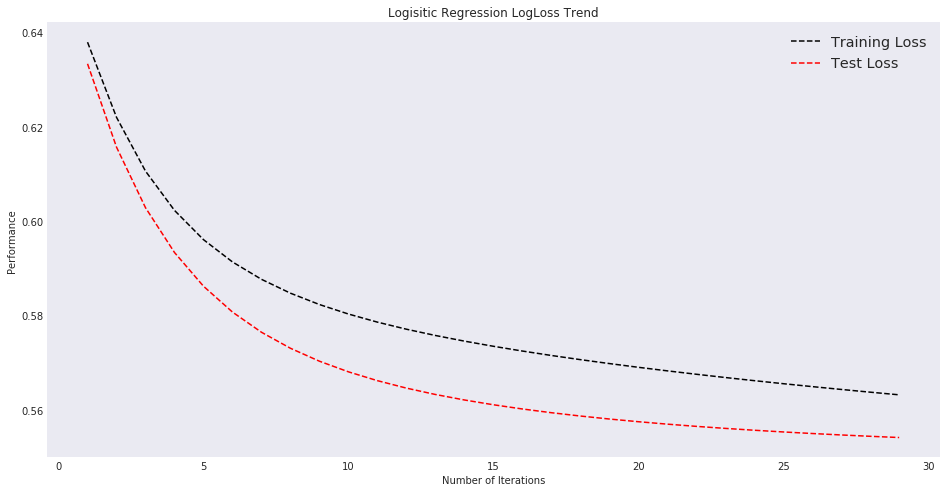

In [316]:
LR_LogLoss_learningRate_point2 = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_LogLoss_learningRate_point2

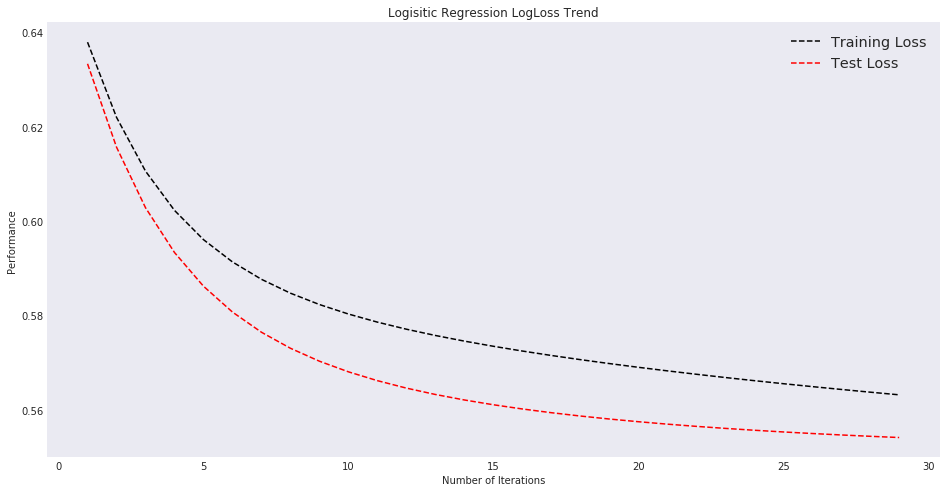

In [317]:
LR_LogLoss_lasso = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_LogLoss_lasso

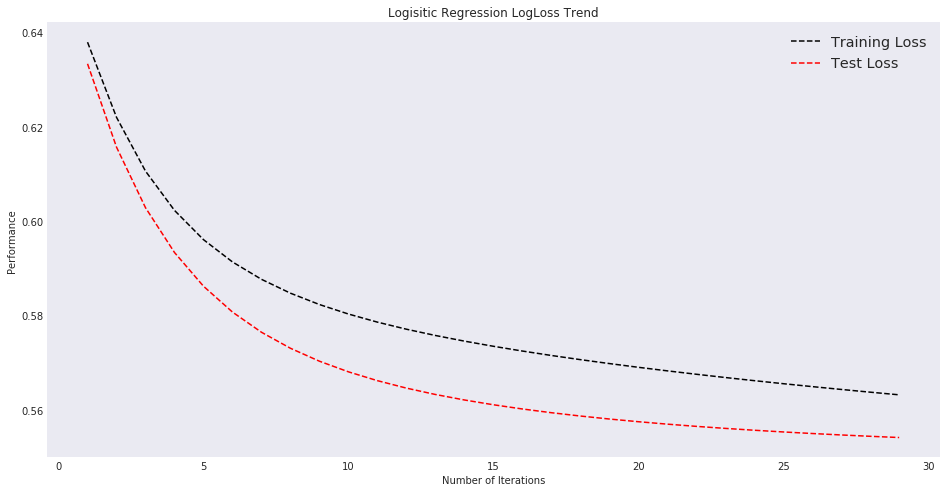

In [318]:
LR_Loss_original = plotErrorCurves(logLossTrain, logLossTest, title = 'Logisitic Regression LogLoss Trend')
LR_Loss_original

In [319]:
def plotPerformance(accuracy, f1_score, title = None):
    """
    Helper function for plotting.    
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(accuracy)))[1:]
    ax.plot(x, accuracy[1:], 'r--', label='Accuracy')
    ax.plot(x, f1_score[1:], 'k--', label='F1_score')
    #ax.plot(x, precision[1:], 'g--', label='Precision')
    #ax.plot(x, recall[1:], 'b--', label='Recall')

    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Performance')
    if title:
        plt.title(title)
    plt.show()
    
    #precision, recall

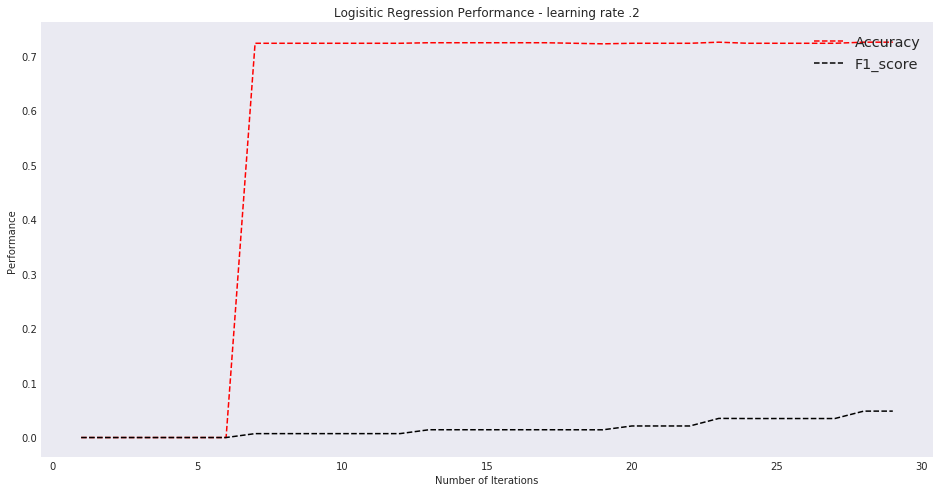

In [320]:
LR_performance_learningRate_point2 = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - learning rate .2')
LR_performance_learningRate_point2

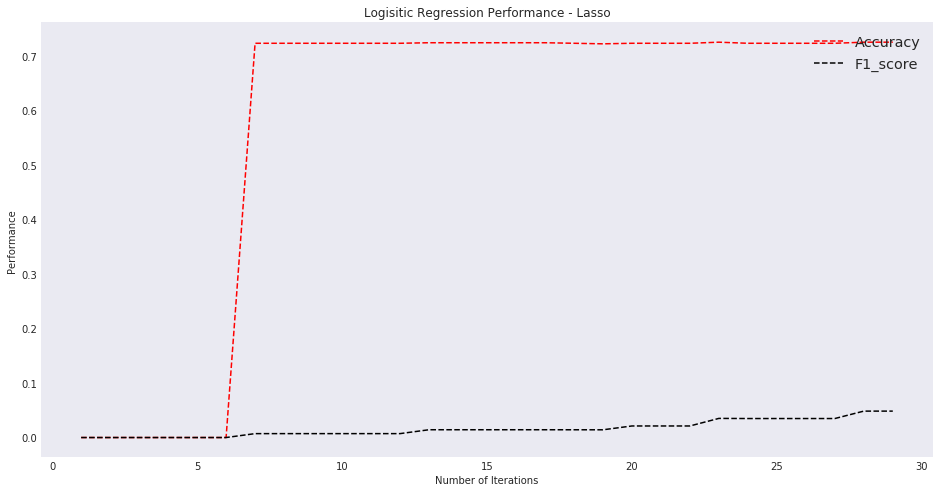

In [321]:
LR_performance_lasso = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - Lasso')
LR_performance_lasso

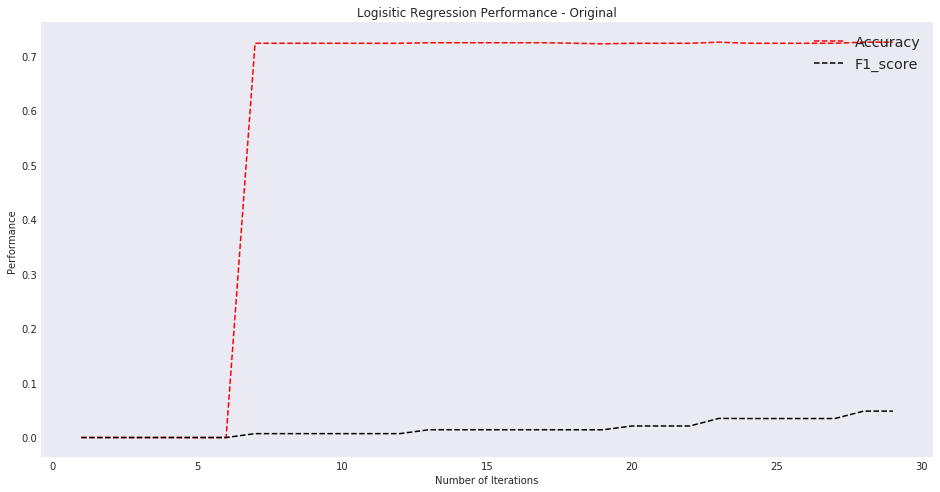

In [322]:
LR_performance_original = plotPerformance(accuracy, f1_score, title = 'Logisitic Regression Performance - Original')
LR_performance_original

In [323]:
def plotROCcurves(recall, false_positive_rate, title = None):
    """
    Helper function for plotting.    
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    #x = list(range(len(recall)))[1:]
    #y = list(range(len(false_positive_rate)))[1:]
    
    #ax.plot(false_positive_rate[1:], recall[1:], 'r--', label='False Positive Rate')

    ax.plot(false_positive_rate, recall, 'r--')

    #ax.plot(x, false_positive_rate[1:], 'r--', label='False Positive Rate')
    #ax.plot(y, recall[1:], 'k--', label='True Positive Rate')

    #ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.show()

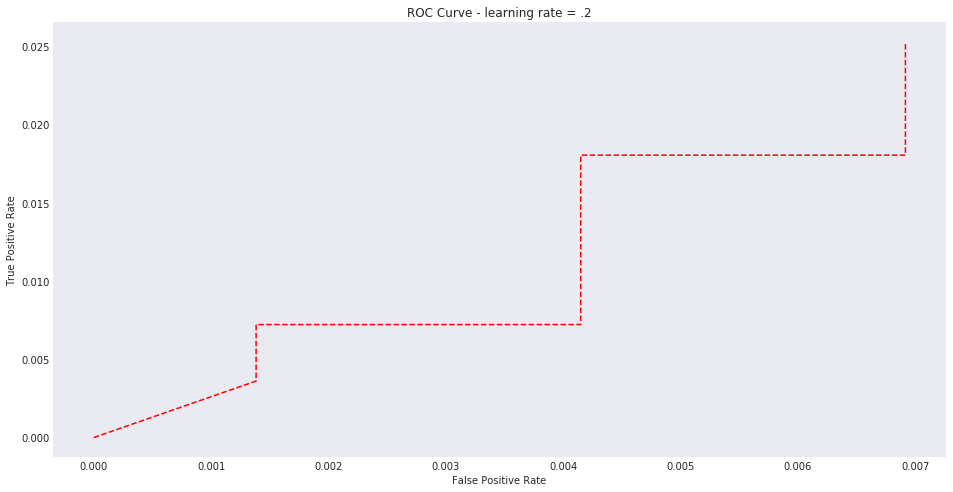

In [324]:
ROC_learning_rate2 = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - learning rate = .2")
ROC_learning_rate2

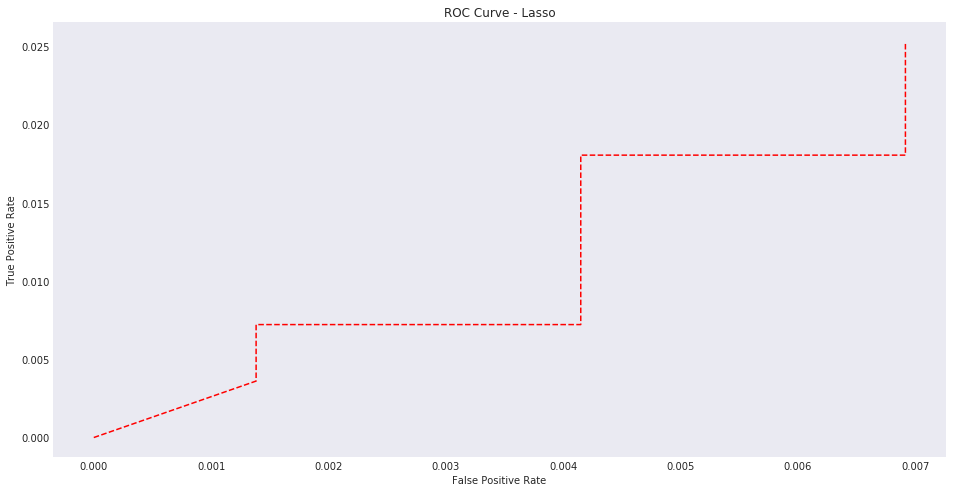

In [325]:
ROC_lasso = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - Lasso")
ROC_lasso 

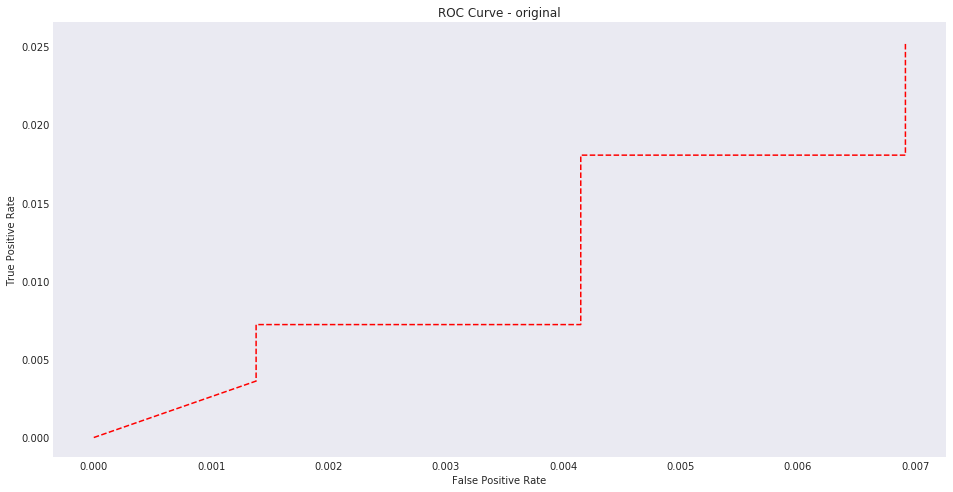

In [326]:
ROC_original = plotROCcurves(recall, false_positive_rate, title = "ROC Curve - original")
ROC_original 

### PART B: Random Forest

### 3.2 Random Forest (RF)

### 3.2.1 Random Forest Algorithm Details

Random Forest:
    
1. Why we chose RF for this data set?
2. Concepts of RF:
3. How does the home grown implementation work? + Flow diagram
4. Tuning parameters used
5. Cross validation

### 3.2.2 Homegrown Implementation of RF 

In [ ]:
# Test the random forest algorithm
seed(2)

# load and prepare data
filename = 'data/toy.csv'
FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']
NUM_FIELDS = FIELDS[0:13] + ['Label']

#toy_dataset = load_csv(filename)
toy_df = pd.read_csv(filename)
numeric_df = toy_df[NUM_FIELDS].copy()
print(numeric_df.info())
print(numeric_df.iloc[0])
dataset = numeric_df.values.tolist()
print(dataset[0])

In [23]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
        dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        if row[column] == 'null':
            row[column] = None
        else:
            row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    # useful if label column coming as categories
    for i, value in enumerate(unique):
        lookup[value] = i 
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            # gives one random number
            index = randrange(len(dataset_copy))
            # pop this random number from dataset
            fold.append(dataset_copy.pop(index))
        # add fold generated to list of folds
        dataset_split.append(fold)
    return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    global flag
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for i,fold in enumerate(folds):
        train_set = list(folds)
        train_set.remove(fold)
        # Converting list of lists to list
        # Ex. converts [[1],[2],[3]] to [1,2,3]
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            # Setting the label to None in test set
            row_copy[-1] = None
            test_set.append(row_copy)
        trees, predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = round(accuracy_metric(actual, predicted),4)
        scores.append(accuracy)
        # using these flags so that the graph will have the nodes of one tree only and will not merge mutliple trees
        if i == len(folds)-1 and flag==1:
            decisiontree= trees[0]
            visit(decisiontree, 0) 
            graph.write_png('decision_tree_graph.png')  
            #print(graph)
            flag = 2
            #print(yaml.dump(decisiontree, default_flow_style=False)) #print(decisiontree)
    return scores
 
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    # index here is the column index in dataset
    # value is the column/feature value based on which split has to be done 
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes): 
    # classes: number of output/label classes
    # number of split branches at a split 
    # ex. if groups = 2, meaning left and right node of the splits
    
    # count all samples at split point
    # total number of samples in left and right nodes 
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero - if there are no samples in a node
        if size == 0: 
            continue
        score = 0.0
        # score the group based on the score for each class
        node_labels = [row[-1] for row in group]
        for class_val in classes:
            # count the no. of samples of class = 1,0 etc. 
            p = node_labels.count(class_val) / size
            # calculate unweighted gini index
            score += p * (1-p)
        # weight the group score by its relative size
        # calculate gini index by weighing by the number of instances
        gini += score * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset, n_features):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    features = list()
    while len(features) < n_features:
        index = randrange(len(dataset[0])-1)
        if index not in features:
            features.append(index)
    for index in features:
        # Get unique set of values for a feature (index)
        unique_values = set([row[index] for row in dataset])
        # use test split to get the distribution of nodes for each value 
        # get gini index of this test split 
        for value in unique_values:
            # groups here are the left and right node samples after splitting on the value
            groups = test_split(index, value, dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, value, gini, groups
    # returns a node with the index with which it has to be split, value and two groups after split
    features_importance[str(FIELDS[b_index])] += float(b_score)
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    # set the label of the terminal node to be the dominant label of the node samples based on count
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    # split is called on the root node to iteratively build the tree
    split(root, max_depth, min_size, n_features, 1)
    return root # this will have the entire tree
 
# Make a prediction with a decision tree
def predict(node, row):
    # node here will be the root node
    if row[node['index']] < node['value']:
        # if the left branch is a node
        # call predict again to pass row down that node
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
        # else if it is terminal node, just return the label value
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample
 
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)

# Building a tree traversal and graph structure for visualization 
def visit(node, depth, parent = None):
    feature=node['index']
    feature = FIELDS[feature]
    feature_value=node['value']
    left_node = node['left']
    right_node = node['right']
    child_nodes = [left_node, right_node]
    
    if depth ==0:            
        node_root = "D"+str(depth)+"_"+str(feature)
    else:
        parent = FIELDS[parent]
        node_root = "D"+str(depth)+"_"+str(parent)
    
    # processing left_child
    if isinstance(left_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS[left_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label="L "+str(feature_value)))
        visit(left_node,depth+1, parent=left_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(left_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="L "+str(feature_value)))
    
    # processing right_child
    if isinstance(right_node, dict):
        node_child = "D"+str(depth+1)+"_"+str(FIELDS[right_node['index']])
        graph.add_edge(pydot.Edge(node_root, node_child, label='R '+str(feature_value)))
        visit(right_node,depth+1, parent=right_node['index'])
    else:
        node_terminal = "D"+str(depth+1)+"_Class_"+str(right_node)
        graph.add_edge(pydot.Edge(node_root, node_terminal, label="R "+str(feature_value)))


# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        decisiontree = build_tree(sample, max_depth, min_size, n_features)
        trees.append(decisiontree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(trees, predictions)


# get_accuracy
def get_accuracy(n_trees, n_folds,  max_depth, min_size):
    accuracy_list = []
    global flag
    global features_importance
    print("N-folds:", n_folds, " Max_depth:", max_depth, " Min size:", min_size)
    for n_trees in number_of_trees:
        scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
        print('Trees: %d' % n_trees)
        print('Scores: %s' % scores)
        accuracy = round((sum(scores)/float(len(scores))),4)
        accuracy_list.append(accuracy)
        print('Mean Accuracy: %.3f%%' % accuracy)
    # setting flag back to 1 for next call of get_accuracy
    flag = 1
    features_importance = sorted(features_importance.items(), key=operator.itemgetter(1))
    features_importance = [(item[0],round(item[1],2)) for item in features_importance]
    print('Features in decreasing order of importance (summed gini index for a feature across all trees - lower gini index better):\n', features_importance)

### 3.2.3 Training and Testing Homegrown RF on Toy Dataset

In [ ]:
graph = pydot.Dot(graph_type='digraph')
flag = 1
sample_size = 1.0
n_features = int(sqrt(len(dataset[0])-1))
number_of_trees = [1, 5, 10, 20, 30, 40, 50, 75,100,]#200]
features_importance = defaultdict(float)

# calling get_accuracy for training RF
get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 10)

# display sample decision tree built
Image(filename="decision_tree_graph.png")

### 3.2.4 Comparing RF Accuracy with various Tuning Parameters

In [ ]:
#Plotting graphs 
plt.figure(figsize=(15,5),) 
plt.subplot(1,2,1)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Varying Depth, Fixed Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 20), color='aqua')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 9, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 11, min_size = 20), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=7 min_size=20')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=9 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=11 min_size=20')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])
plt.subplot(1,2,2)
plt.title("Accuracy of Random Forest vs Number of Trees \n Number of Folds = 3, Depth=5,7, Varying Min.Size")
plt.xlabel('Number of Trees')
plt.ylabel('Classification Accuracy')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 20), color='red')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 5, min_size = 10), color='aqua')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 20), color='darkorchid')
plt.plot(number_of_trees, get_accuracy(n_trees, n_folds = 3, max_depth = 7, min_size = 10), color = 'lime')
red_patch = mpatches.Patch(color='red', label='depth=5 min_size=20')
aqua_patch = mpatches.Patch(color='aqua', label='depth=5 min_size=10')
darkorchid_patch =  mpatches.Patch(color='darkorchid', label='depth=7 min_size=20')
lime_patch =  mpatches.Patch(color='lime', label='depth=7 min_size=10')
plt.legend(handles=[red_patch, aqua_patch, darkorchid_patch, lime_patch])

### 3.2.5 RF Performance and Accuracy on Toy Dataset

Notes on tuning parameters:
 
1. How long it takes to train 
2. What is the accuracy compared to baseline?
3. How does accuracy change with various tuning parameters?

### 3.2.6 Scaling Random Forest

Scaling RF:
    
4. Why is RF suitable for scaling?
5. How to scale RF?
6. Potential challenges while sclaing:
7. Decision to use homegrown RF on toy but use Spark ML on full 

## 4. Algorithm Implementation - Using Full Dataset

### PART A: DATA TRANSFORMATION USING DATAFRAMES

### 4.1 Data Transformation Pipeline 

Notes: How EDA data tranformations decisions were used for building pipeline?

In [ ]:
# Code

### PART B: LR AND RF WITH SPARK ML

### 4.2 LR in Spark ML

In [ ]:
# Code

### 4.3 RF in Spark ML

In [ ]:
# Code

### 4.4 Comparing Models

Notes on Models:
    1. Model training time details for LR and RF
    2. Comparing accuracy for LR and RF 

## 5. Application of Course Concepts

### 5.1 Course Concepts:

1. Scalability
2. Associative and Commutative 
3. No state dependency 
4. Algorithms chosen with this criteria
5. Bias/Variance Tradeoff 
6. Regularization 

### 5.2 Conclusion:
Accuracy of Models and Performance Notes:
    
### 5.3 Future Ideas for Implementation:
    